# Master thesis - Datacentric aproach to time series forecasting 

Authors:
- Berling Gustav - gusbe498@student.liu.se
- Janzén Albin - albja295@student.liu.se

Import libraries, data and set global parameters

In [93]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
from matplotlib.patches import Rectangle
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(1234)
tf.keras.utils.set_random_seed(1234)

# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

#Plot colors
colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']


/tmp/ipykernel_405689/2365416793.py:20: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  og_df = pd.read_csv('data/Structured/all_data.csv')


Remove empty data and change order of columns

In [94]:
#Drop all empty columns
df = og_df.dropna(axis=1, how='all')
del og_df
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

#Fill missing values with the previous value
df = df.fillna(method='ffill')
#Fill missing values with the next value
df = df.fillna(method='bfill')
#Remove collumns with only one value
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)

#Change index of target variable  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)

#Set date for end of test data
test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]

#Remove dates from dataframe
dates = df.pop('Date')
years = [year.split("-")[0] for year in dates]

#Save number of features
n_original_features = df.shape[1]
print(n_original_features)


# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

/tmp/ipykernel_405689/2203471330.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1, 'SE1', first_column)


470


In [177]:
# Fit PCA to identify which features contribute the most to variance
pca = PCA()
pca.fit(df)

n_used_features = 15

# Get explained variance ratios of each principal component
variance_ratios = pca.explained_variance_ratio_

# Sort features by their explained variance ratios and select the top 20
top_n_features_idx = variance_ratios.argsort()[::-1][:n_used_features]
top_n_features = df.columns[top_n_features_idx]

# Select only the top 20 features from the original data
data_top_n = df[top_n_features]
df = data_top_n
n_features = n_used_features
colorpicker = plt.cm.jet(np.linspace(0,1,n_features))

In [96]:
data_top_n

SE1       Gas  Sveriges Förbrukning MWh  Summa Vindkraft  \
0       0.010706  0.244756                  0.515857         0.000228   
1       0.010706  0.244756                  0.528866         0.000228   
2       0.010706  0.244756                  0.544168         0.000228   
3       0.010706  0.244756                  0.561294         0.000228   
4       0.010706  0.244756                  0.564332         0.000228   
...          ...       ...                       ...              ...   
202873  0.016712  0.117676                  0.572311         0.611809   
202874  0.015543  0.117676                  0.600897         0.688117   
202875  0.004791  0.117676                  0.624324         0.738961   
202876  0.001538  0.117676                  0.652531         0.746551   
202877  0.003051  0.117676                  0.676991         0.772655   

        Summa Vattenkraft  Summa kärnkraft  Summa Värmekraft  \
0                0.170263         0.840188          0.079535   
1                0.170263         0.840188          0.079535   
2                0.170263         0.840188          0.079535   
3                0.170263         0.840188          0.079535   
4                0.170263         0.840188          0.079535   
...                   ...              ...               ...   
202873           0.370550         0.497149          0.222482   
202874           0.292388         0.497346          0.212010   
202875           0.224827         0.497275          0.191142   
202876           0.198172         0.497320          0.171365   
202877           0.161743         0.497476          0.152372   

        Summa Ospecificerat  Summa Solkraft  Sveriges Produktion MWh  \
0                  0.646573        0.000000                 0.532359   
1                  0.646573        0.000000                 0.513562   
2                  0.646573        0.000000                 0.483429   
3                  0.646573        0.000000                 0.444582   
4                  0.646573        0.000000                 0.418088   
...                     ...             ...                      ...   
202873             0.000505        0.000366                 0.573338   
202874             0.000606        0.000357                 0.559150   
202875             0.000384        0.000352                 0.535871   
202876             0.000240        0.000312                 0.517452   
202877             0.000296        0.000346                 0.502794   

        Import/Export  Bioenergy and renewable waste  Biomass and biogas  \
0            0.547457                       0.000000            0.000405   
1            0.556553                       0.000000            0.000405   
2            0.578714                       0.000000            0.000405   
3            0.610964                       0.000000            0.000405   
4            0.644758                       0.000000            0.000405   
...               ...                            ...                 ...   
202873       0.407021                       0.791937            0.972888   
202874       0.388880                       0.791937            0.972888   
202875       0.390241                       0.791937            0.972888   
202876       0.377637                       0.791937            0.972888   
202877       0.365145                       0.791937            0.972888   

        Differently categorized fossil fuels  Differently categorized hydro  
0                                   1.000000                        0.30303  
1                                   1.000000                        0.30303  
2                                   1.000000                        0.30303  
3                                   1.000000                        0.30303  
4                                   1.000000                        0.30303  
...                                      ...                            ...  
202873                              0.47465

<Axes: >

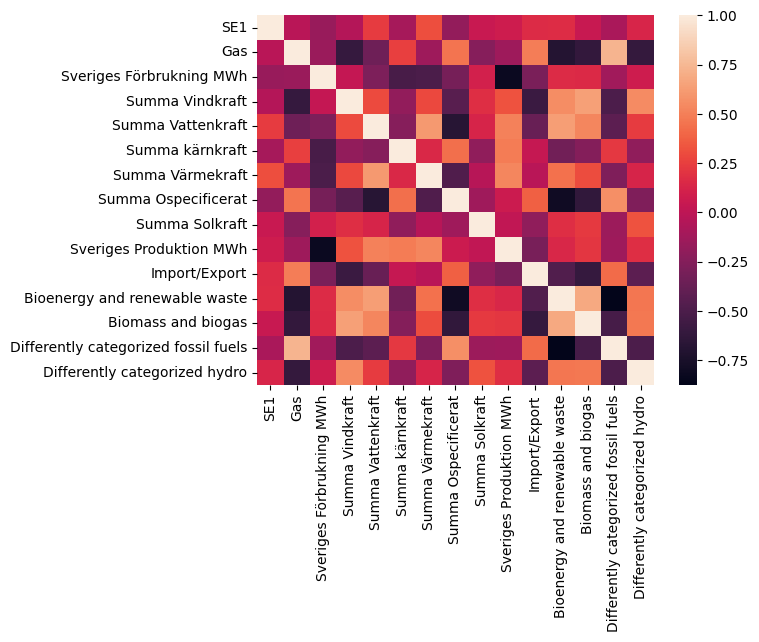

In [97]:
sns.heatmap(df.corr())

Plot target variable

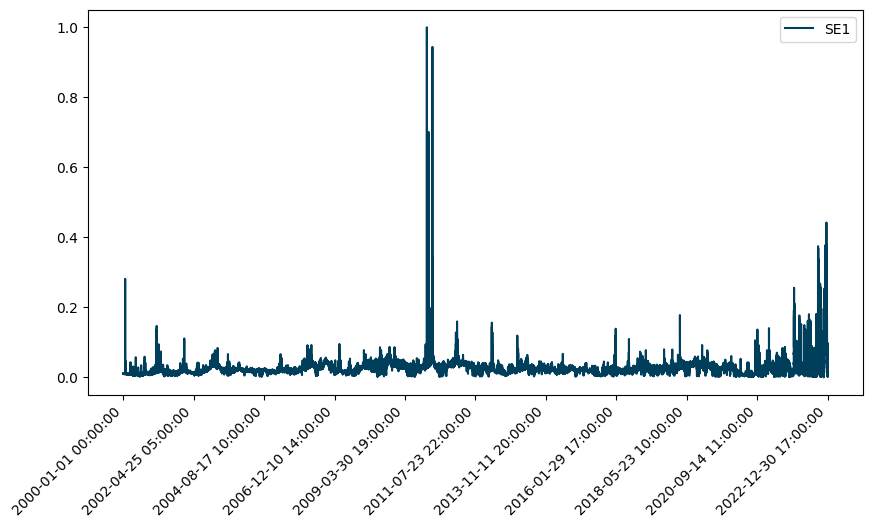

In [98]:
y = df['SE1']
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y, color=colors[0], label='SE1')
ax.legend()
ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
plt.show()



Divide train, validation and test set

In [99]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.05)
val_size = int(len(df) * 0.1)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
train_dates = dates[:val_end-val_size]

val_df = df[val_end-val_size:val_end]
val_dates = dates[val_end-val_size:val_end]

test_df = df[test_end-test_size:test_end]
test_dates = dates[test_end-test_size:test_end]

train_df = pd.concat([train_df, df[test_end:]])
train_dates = pd.concat([train_dates, dates[test_end:]])

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(172448, 15)
(20287, 15)
(10143, 15)


Select target variable and lag the data for forecasting

In [130]:
def create_dataset(data, look_back=1):
    n_features = data.shape[1]
    dataX = np.empty((len(data)-look_back-1, look_back, n_features))
    dataY = np.empty((len(data)-look_back-1))
    for i in range(len(data)-look_back-1):
        dataX[i] = data[i:i+look_back]
        dataY[i] = data[i+look_back][0]
    return dataX, dataY

look_back = 12
X_train, y_train = create_dataset(train_df.values, look_back)
X_val, y_val = create_dataset(val_df.values, look_back)
X_test, y_test = create_dataset(test_df.values, look_back)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(172435, 12, 15)
(172435,)
(20274, 12, 15)
(20274,)
(10130, 12, 15)
(10130,)


Adapt the data to the batching

In [131]:
batch_size = 128
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
train_dates = train_dates[:num_samples_train]

X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
val_dates = val_dates[:num_samples_val]

X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
test_dates = test_dates[:num_samples_test]

# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

(172435, 12, 15)


Plot the data split (only target variable is shown but is done on the whole dataset)

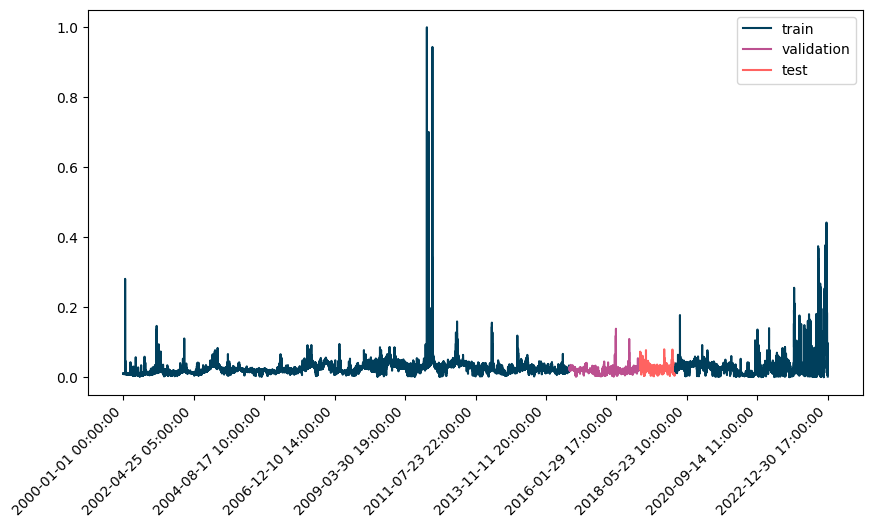

In [132]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(0,val_end-val_size), y_train[0:val_end-val_size], color=colors[0], label='train')
ax.plot(np.arange(val_end-y_val.shape[0], val_end), y_val, color=colors[2], label='validation')
ax.plot(np.arange(test_end-y_test.shape[0], test_end), y_test, color=colors[3], label='test')
ax.plot(np.arange(test_end,(test_end + y_train[val_end-val_size:].shape[0])), y_train[val_end-val_size:], color=colors[0])
ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
ax.legend()
plt.show()

Create the LSTM model

In [133]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, None, n_features), stateful=True),
    tf.keras.layers.Dense(1)
])

Class for plotting the learning process, used as a callback for the compile function of the model

In [134]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color=colors[0])
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color=colors[3])
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

Compile and fit the model: train the model

In [135]:
def compile_and_fit(model, X_train, y_train, patience=10):
  tf.keras.backend.clear_session()
  model.reset_states()
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    restore_best_weights=True,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.build(X_train.shape)
  print(model.summary())
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=batch_size, verbose=1,
                      callbacks=[early_stopping,PlotLearning()])
  return history

# Data Analysis functions

feature_cutoff: Plot and calculate data cutoff based on mae impact

In [163]:
def feature_cutoff(baseline_mae, n_cols, iteration, cutoff = 0, prime = 0):
    df = pd.read_csv(iteration + '_feature_importance.csv', header=None, names=['feature','mae'])
    df = df.sort_values('mae')

    plt.figure(figsize=(10,n_cols//5))
    plt.barh(np.arange(n_cols + 1),df.mae, color=colors[0])
    plt.yticks(np.arange(n_cols + 1),df.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1,n_cols + 1))

    
    a_set_columns = [] 
    b_set_columns = []
    prime_set_columns = []

    df = df[df.feature != 'Baseline']

    if cutoff != 0:
        if cutoff == 1:
            cutoff = np.std(df[df['mae'] < baseline_mae]).mae
        a_set_columns = df[df['mae'] >= baseline_mae - cutoff].feature
        b_set_columns = df[df['mae'] < baseline_mae - cutoff].feature
        plt.plot([baseline_mae-cutoff,baseline_mae-cutoff],[-1,n_cols+1], '--', color=colors[1],
                    label=f'Cutoff threshold\nMAE={baseline_mae-cutoff:.4f}')

    if prime != 0:
        if prime == 1:
            prime = np.std(df[df['mae'] > baseline_mae]).mae
        prime_set_columns = df[df['mae'] > baseline_mae + prime].feature
        plt.plot([baseline_mae+prime,baseline_mae+prime],[-1,n_cols+1], '--', color=colors[3],
                    label=f'Cutoff threshold\nMAE={baseline_mae+prime:.4f}')

    plt.plot([baseline_mae,baseline_mae],[-1,n_cols + 1], '--', color=colors[4],
                label=f'Baseline \nMAE={baseline_mae:.4f}')
    plt.ylabel('Feature',size=14)
    plt.legend()
  
    plt.show()
    return a_set_columns, b_set_columns, prime_set_columns

unique_average: Compute the average number of features that has low data uniqueness

In [137]:
def unique_average(data):
    list = []
    for i in range(data.shape[1]):
        list.append(data.iloc[:,i].nunique())
    list = pd.DataFrame(list)
    print('Average amount of unique values per feature:')
    print(np.mean(list))
    print('Average percentage of unique values per feature:')
    print(np.mean(list)/data.shape[0])
    plt.plot(list, color=colors[0], label='Unique values')
    plt.legend()

boxplot: Create a boxplot

In [138]:
def boxplot(data, columns):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, columns.shape[0]//5))

    meds = data.median()
    meds.sort_values(ascending=False, inplace=True)
    data = data[meds.index]

    bplot1 = ax1.boxplot(data, vert=False, patch_artist=True, labels=columns)  

    plt.setp(bplot1["boxes"], facecolor=colors[0])
    plt.setp(bplot1["whiskers"], color=colors[2])
    plt.setp(bplot1["fliers"], markeredgecolor=colors[4])
    plt.show()

feature_importance: Calculate feature importance

In [139]:
import os
def feature_importance(model, X, y, df, batch_size, iteration):
    n_permutations = 5
    COLS = list(df.columns[1:])
    n_cols = len(COLS)
    print('Computing LSTM feature importance...')

    preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
    baseline_mae = np.mean(np.abs( preds-y ))
    print(baseline_mae)
    if not os.path.exists(iteration + '_feature_importance.csv'):
        fi_df = pd.DataFrame(['Baseline', baseline_mae]).T
        fi_df.to_csv(iteration + '_feature_importance.csv', index=False, header=False)
        for k in range(n_cols):
            save_col = X[:,:,k].copy()
            if k % 50 == 0:
                print(k)
            mae_list = np.zeros(n_permutations)
            
            for i in range(n_permutations):
                X[:,:,k] = np.random.permutation(X[:,:,k])
                preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
                mae_list[i] = np.mean(np.abs( preds-y ))
            
            mae = np.mean(mae_list) 
            fi_df = pd.DataFrame([COLS[k], mae]).T
            fi_df.to_csv(iteration + '_feature_importance.csv', mode='a', index=False, header=False)
            X[:,:,k] = save_col
    
    return baseline_mae, n_cols

time_slice_mae_plot: plot the mae over batch time slices

In [140]:
def time_slice_mae_plot(model, X, y, batch_size, dates):
    assert X.shape[0] % batch_size == 0
    n_batches = int(X.shape[0] / batch_size)
    time_slice_mae = pd.DataFrame(np.zeros(n_batches), columns=['mae'])
    for i in range(n_batches):
        data = X[i*batch_size:(i+1)*batch_size,:,:]
        preds = model.predict(data, verbose=0, batch_size=batch_size).squeeze() 
        time_slice_mae.iloc[i] = np.mean(np.abs(preds-y[i*batch_size:(i+1)*batch_size]))
    time_slice_mae.reset_index(drop=True, inplace=True)
    pred = model.predict(X, verbose=0, batch_size=batch_size).squeeze()

    x_index = np.arange(0, y.shape[0], batch_size)

    fig,(ax, ax2)  = plt.subplots(1,2, figsize=(20, 5))
    
    ax.set_ylabel("SE1",
                fontsize=14, color='grey')

    ax.fill_between(
        np.arange(0,len(pred)), pred, y, where=(pred > y), 
        interpolate=True, color=colors[2], alpha=1, 
        label="Larger forecast", zorder=2
    )
    ax.fill_between(
        np.arange(0,len(pred)), pred, y, where=(pred < y), 
        interpolate=True, color=colors[0], alpha=1, 
        label="Lower forecast", zorder=2
    )
    print(time_slice_mae)
    ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
    ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
    ax.legend()
    ax2.plot(x_index, time_slice_mae.iloc[:,0], color=colors[0], label='Slice MAE')
    std_dev = np.std(time_slice_mae).mae + np.mean(time_slice_mae).mae
    ax2.axhline(y=std_dev, color=colors[4])
    ax2.set_xticks(np.arange(0, len(dates), len(dates)//10))
    ax2.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
    ax2.legend()
    plt.show()

    result = time_slice_mae['mae'] > std_dev
    return result, pred


getSlices: get the interesting slices to analyse

In [141]:
def getSlices(X, y, batch_slices, batch_size, preds, dates):
    indices = []
    n_batches = int(X.shape[0] / batch_size)
    for i in range(n_batches):
            if batch_slices[i]:
                    indices.append({'from': i*batch_size, 'to': i*batch_size+batch_size})
    slices = []

    from_index = indices[0]['from']
    to_index = indices[0]['to']
    last_loop_in_range = False

    for i in range(len(indices)-1):
        if indices[i+1]['from'] - indices[i]['to'] < 720:
            to_index = indices[i+1]['to']
            last_loop_in_range = True
        else:
            slices.append({'from': from_index, 'to': to_index})
            from_index = indices[i+1]['from']
            to_index = indices[i+1]['to']
            last_loop_in_range = False

    if last_loop_in_range:
        slices.append({'from': from_index, 'to': to_index})

    fig, ax = plt.subplots(figsize=(20, 12))
    for i in slices:
        ax.add_patch(Rectangle((i['from'], 0), i['to'] - i['from']+128, np.max(y), facecolor=colors[4], alpha=1, zorder=1))
    
    ax.fill_between(
        np.arange(0,len(preds)), preds, y, where=(preds > y), 
        interpolate=True, color=colors[2], alpha=1, 
        label="Larger forecast", zorder=2
    )
    ax.fill_between(
        np.arange(0,len(preds)), preds, y, where=(preds < y), 
        interpolate=True, color=colors[0], alpha=1, 
        label="Lower forecast", zorder=2
    )
    ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
    ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
    ax.legend()
    
    plt.show()

    return slices

run_analysis_suite: run the data analysis suite based on the above functions

In [142]:
def run_analysis_suite(data, columns):
    print("Data shape: ")
    print(data.shape)
    unique_average(data)
    boxplot(data, columns)

printSliceMae: print the mae of the interesting slices

In [143]:
def printSliceMae(slices, X, y, model, batch_size):
    for i in slices:
        preds = model.predict(X[i['from']:i['to']], batch_size=batch_size, verbose=0)
        print('steps in slice: ', i['to'] - i['from'], '    mae', np.mean(np.abs(preds-y[i['from']:i['to']])))

# Baseline

## Train Baseline

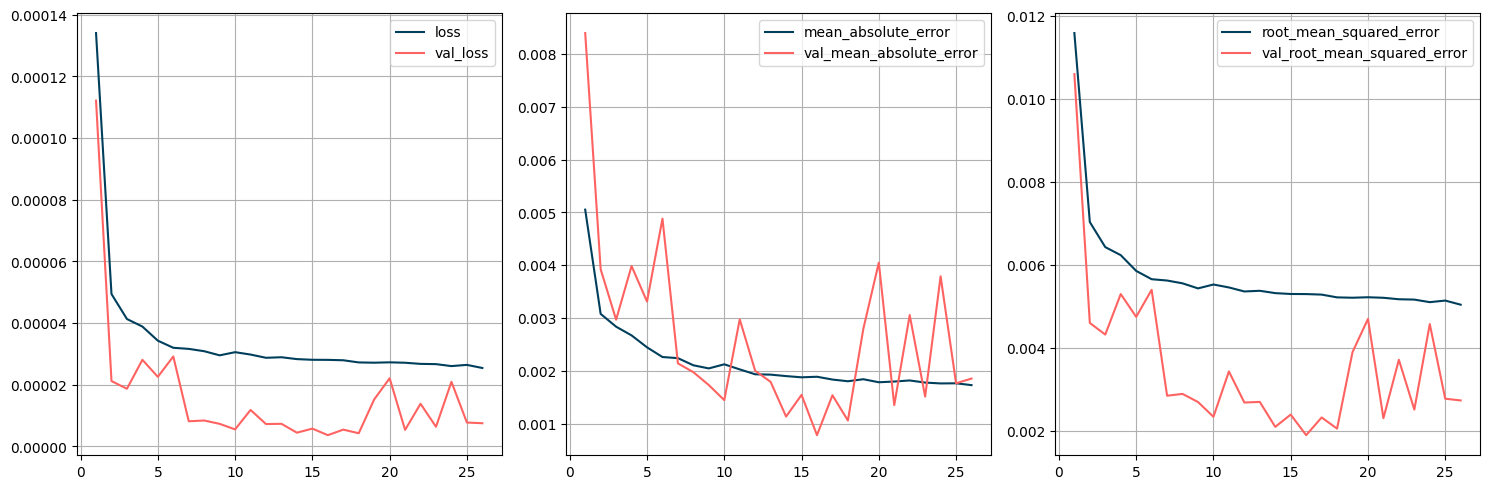

1347/1347 [==============================] - 18s 14ms/step - loss: 2.5398e-05 - mean_absolute_error: 0.0017 - root_mean_squared_error: 0.0050 - val_loss: 7.4797e-06 - val_mean_absolute_error: 0.0019 - val_root_mean_squared_error: 0.0027


In [144]:
history = compile_and_fit(model, X_train, y_train)
model.save_weights('.models/baseline')

## Baseline result/residuals

In [145]:
result = model.predict(X_test, batch_size=batch_size)

79/79 [==============================] - 1s 7ms/step


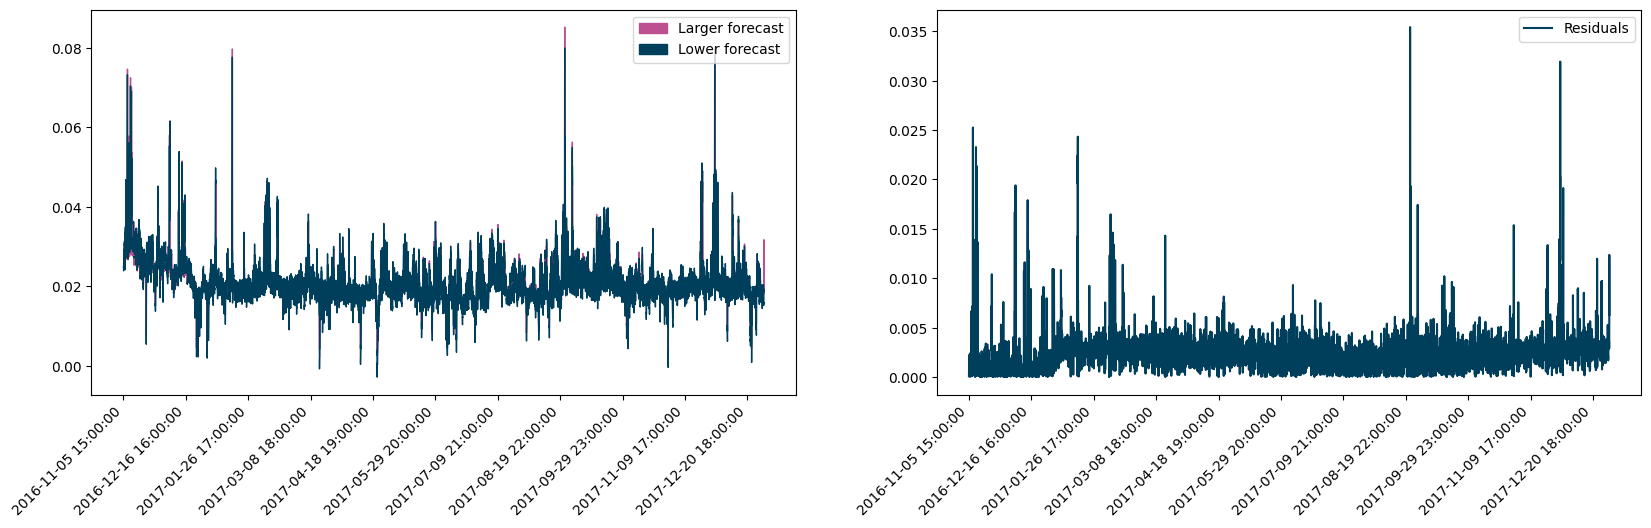

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
result = result.squeeze()
ax1.fill_between(
    np.arange(0,len(result)), result, y_test, where=(result > y_test), 
    interpolate=True, color=colors[2], alpha=1, 
    label="Larger forecast"
)
ax1.fill_between(
    np.arange(0,len(result)), result, y_test, where=(result < y_test), 
    interpolate=True, color=colors[0], alpha=1, 
    label="Lower forecast"
)
ax1.set_xticks(np.arange(0, len(test_dates), len(test_dates)//10))
ax1.set_xticklabels(test_dates[::len(test_dates)//10], rotation=45, ha='right')
residuals = abs(np.subtract(np.array(result), np.array(y_test)))
# residuals = y_test - result
ax1.legend()
ax2.plot(residuals, label='Residuals', color=colors[0])
ax2.legend()
ax2.set_xticks(np.arange(0, len(test_dates), len(test_dates)//10))
ax2.set_xticklabels(test_dates[::len(test_dates)//10], rotation=45, ha='right')
plt.show()

## Baseline feature importance

In [165]:
baseline_mae, n_cols = feature_importance(model, X_val, y_val, df, batch_size, 'baseline')

Computing LSTM feature importance...
0.0007823294629036541


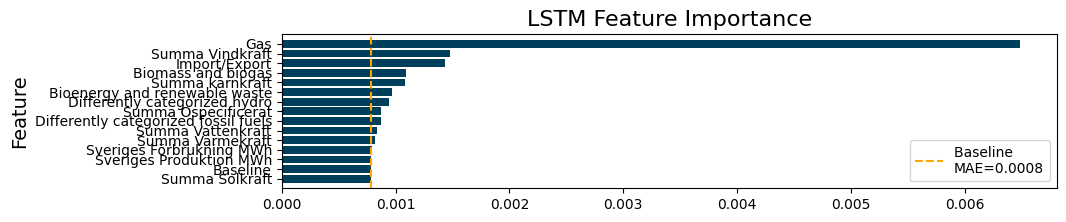

([], [], [])

In [166]:
feature_cutoff(baseline_mae, n_cols, 'baseline', cutoff = 0, prime = 0)

# Iteration 1

Remove unused memory allocations

In [149]:
import gc
gc.collect()

194611

## Feature Importance cutoff

/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3571: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3571: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


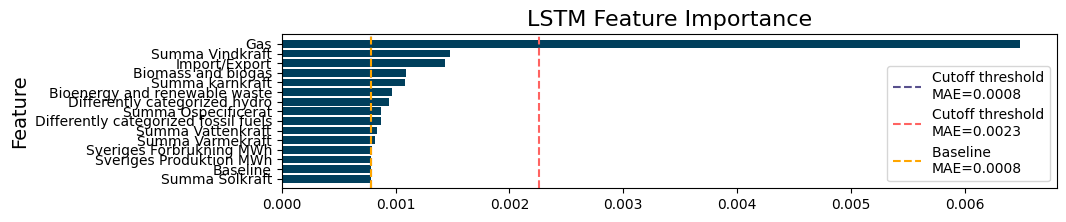

In [167]:
a_set_columns, b_set_columns, prime_set_columns = feature_cutoff(baseline_mae, n_cols, 'baseline', cutoff = 1, prime = 1)

### B set

Data shape: 
(202878, 1)
Average amount of unique values per feature:
0    86717.0
dtype: float64
Average percentage of unique values per feature:
0    0.427434
dtype: float64


/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


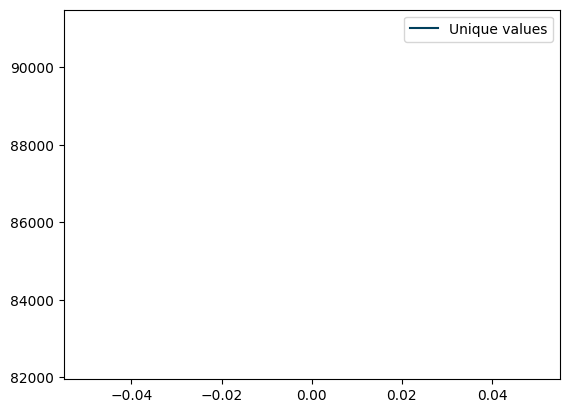

/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/matplotlib/_tight_bbox.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/matplotlib/_tight_bbox.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/matplotlib/patches.py:739: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/matplotlib/transforms.py:2042: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


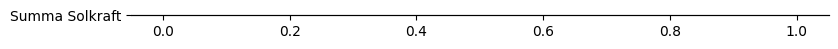

In [151]:
b_set = df[b_set_columns]
run_analysis_suite(b_set, b_set_columns)

### A set

Data shape: 
(202878, 13)
Average amount of unique values per feature:
0    105466.307692
dtype: float64
Average percentage of unique values per feature:
0    0.519851
dtype: float64


/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


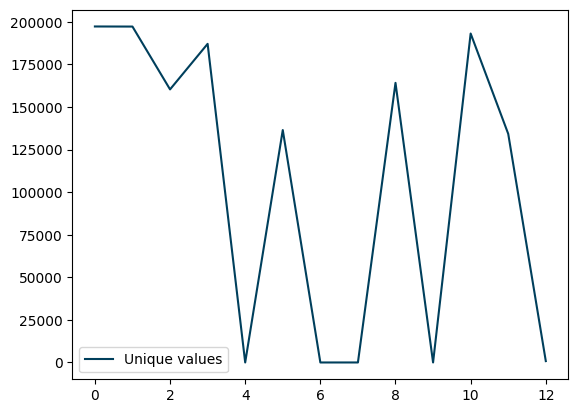

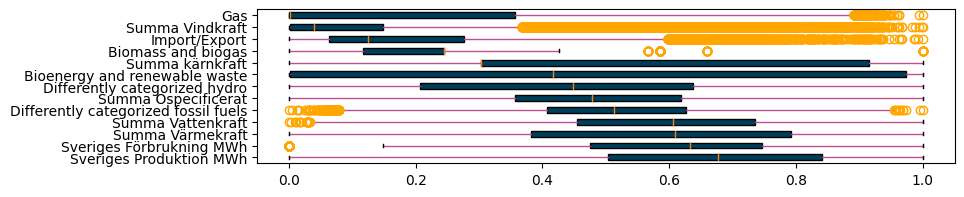

In [152]:
a_set = df[a_set_columns]
run_analysis_suite(a_set, a_set_columns)

### Prime

Data shape: 
(202878, 1)
Average amount of unique values per feature:
0    814.0
dtype: float64
Average percentage of unique values per feature:
0    0.004012
dtype: float64


/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


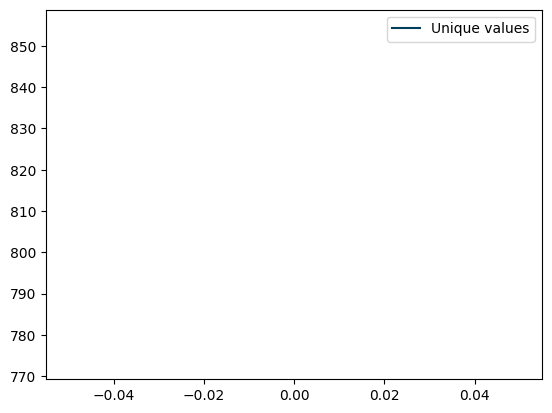

/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/matplotlib/_tight_bbox.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/matplotlib/_tight_bbox.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/matplotlib/patches.py:739: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/matplotlib/transforms.py:2042: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


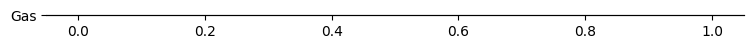

In [153]:
prime_set = df[prime_set_columns]
run_analysis_suite(prime_set, prime_set_columns)

## Time slice selection

Dispose of unused memory

In [154]:
gc.collect()

46480

          mae
0    0.000482
1    0.000483
2    0.000709
3    0.000468
4    0.000498
..        ...
153  0.001560
154  0.000771
155  0.000727
156  0.001384
157  0.001136

[158 rows x 1 columns]


/home/gusbe498/exjobb/masterthesis/exjobb/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


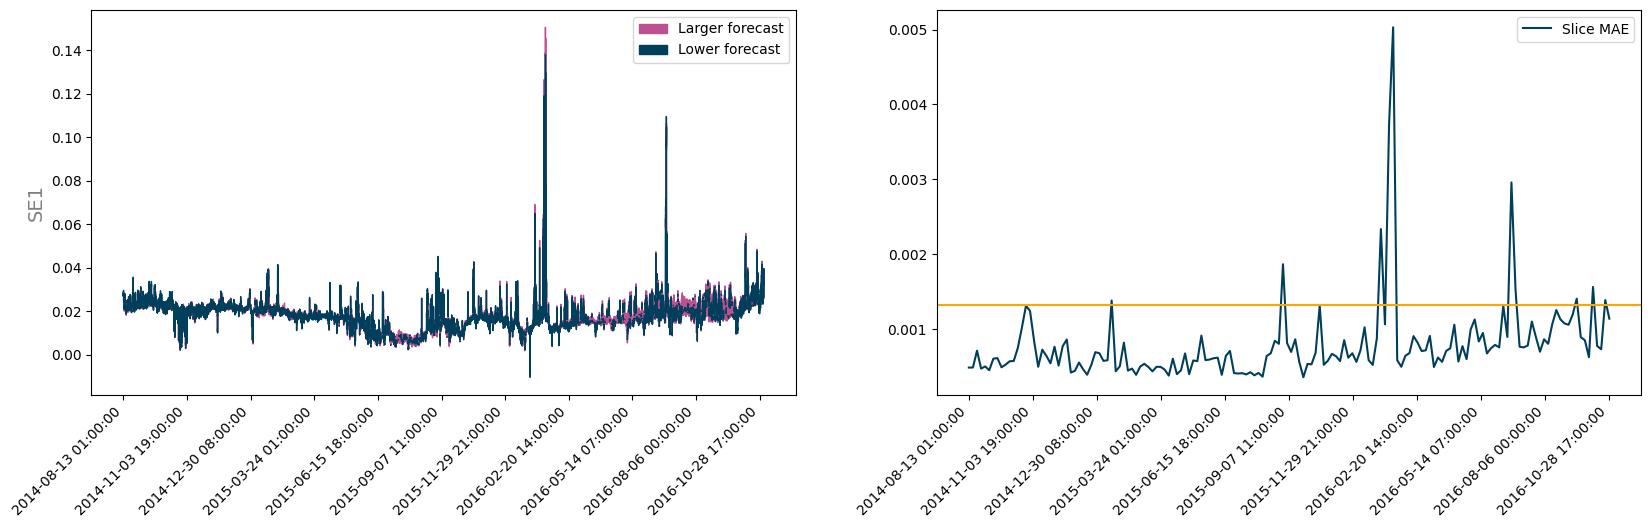

In [155]:
val_interesting_batch_indices, val_preds = time_slice_mae_plot(model, X_val, y_val, batch_size, val_dates)

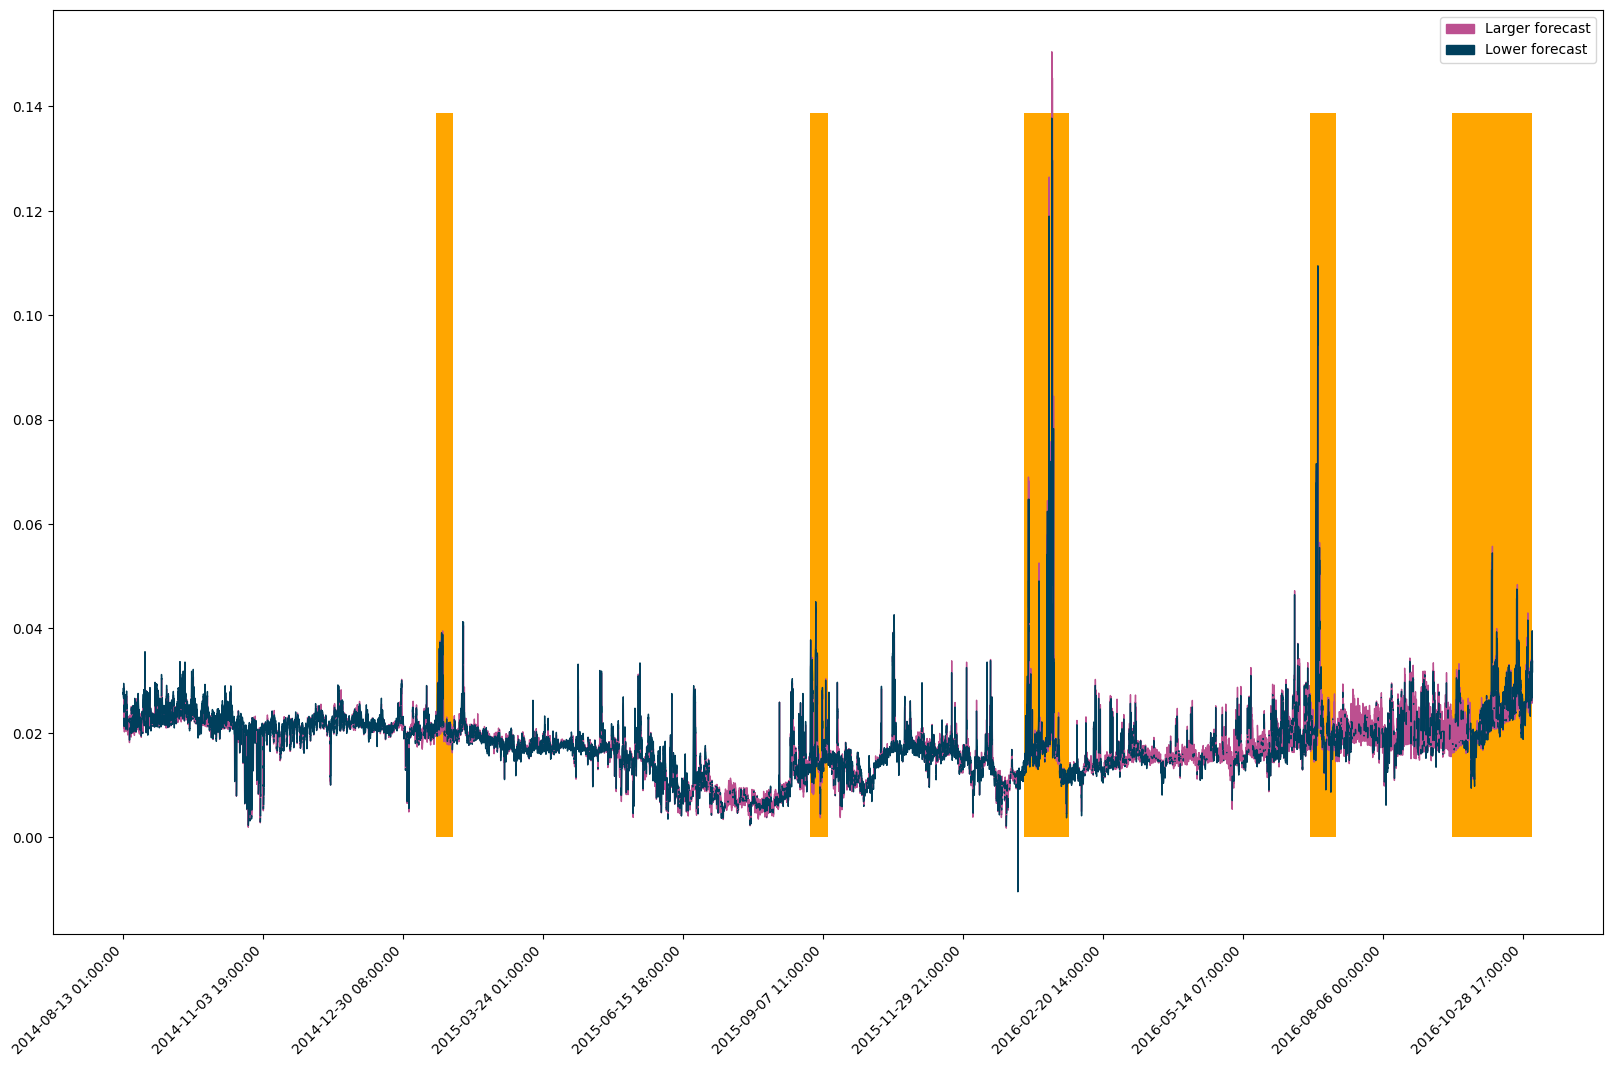

In [156]:
val_slices = getSlices(X_val, y_val, val_interesting_batch_indices, batch_size, val_preds, val_dates)

In [157]:
printSliceMae(val_slices, X_val, y_val, model, batch_size)

steps in slice:  128     mae 0.005805736457373771
steps in slice:  128     mae 0.009120281614326091
steps in slice:  512     mae 0.012059462369594688
steps in slice:  256     mae 0.01307077982551402
steps in slice:  1024     mae 0.005840048259810572


0 0
6 0
12 0
0 1
6 1
12 1


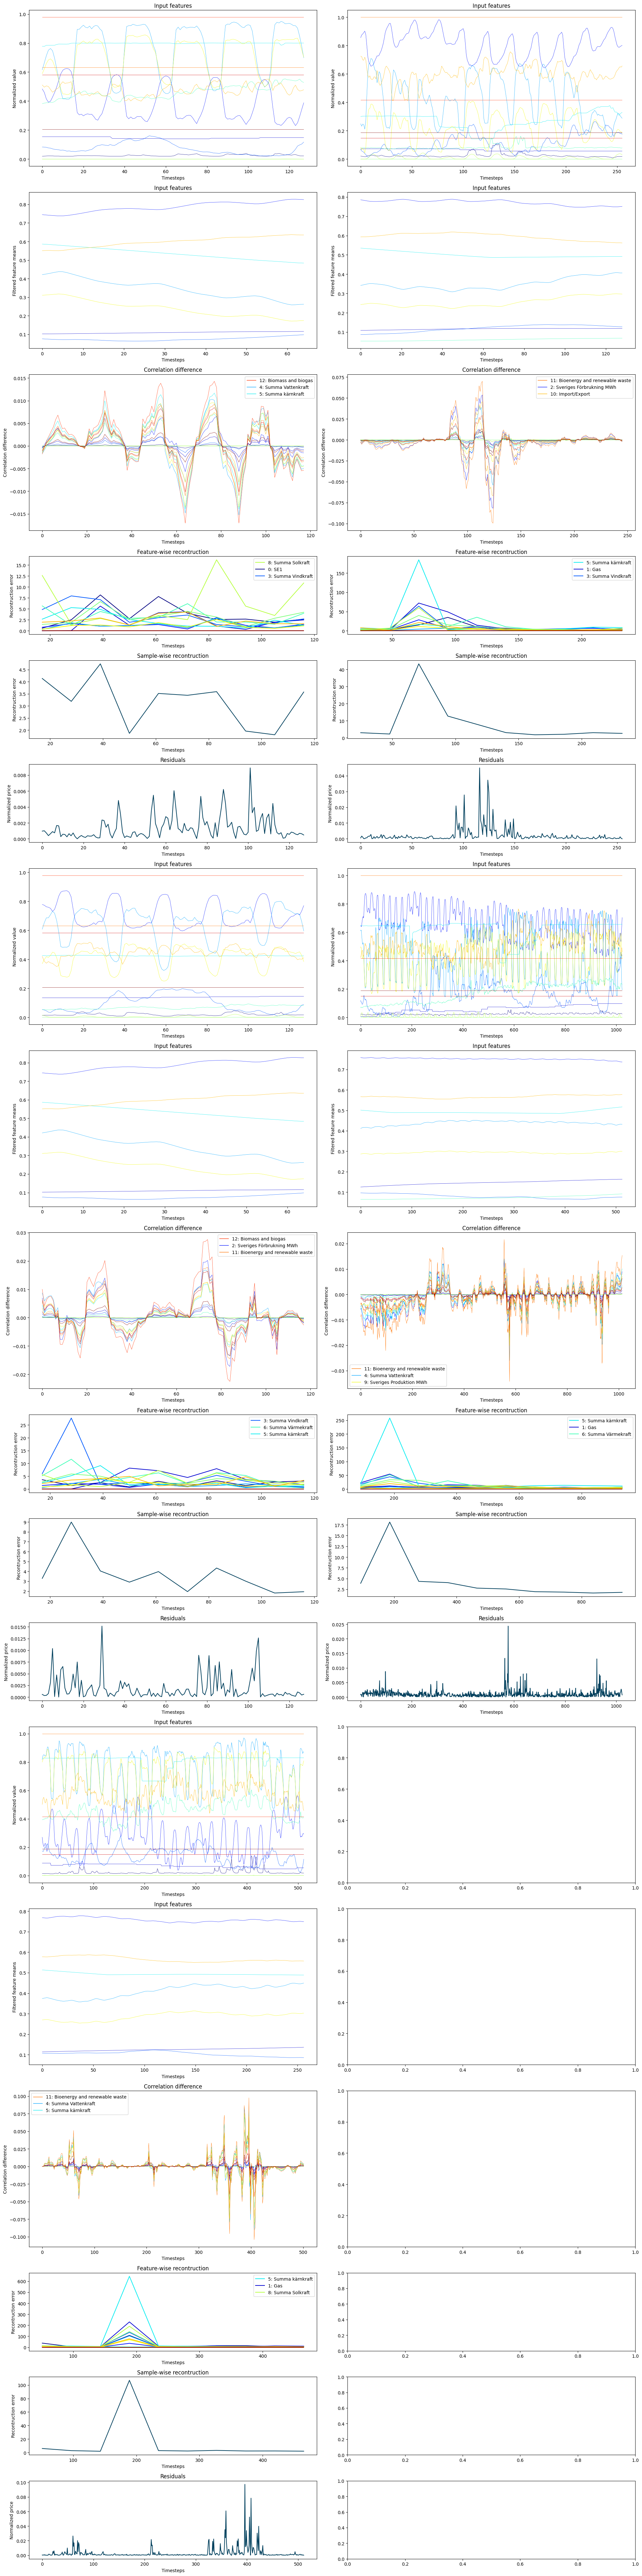

In [190]:

def plot_features(data_slice, axes, x, y):
    
    for i in range(data_slice.shape[2]):
        axes[y,x].plot(data_slice[:,0,i], alpha = 1, linewidth = 0.5, color = colorpicker[i])
    axes[y,x].set_ylabel('Normalized value')
    axes[y,x].set_xlabel('Timesteps')
    axes[y,x].set_title('Input features')
    
def plot_running_mean(data, window, axes, x, y):
    window = data.shape[0]//window
    for i in range(data.shape[2]):
        average_data = []
        for ind in range(data.shape[0] - window + 1):
            average_data.append(np.mean(X_val[ind:ind+window,0,i]))
        if max(average_data) - min(average_data) > 0.01:
            axes[y,x].plot(average_data, alpha = 1, linewidth = 0.5, color = colorpicker[i])
            axes[y,x].set_ylabel('Filtered feature means')
            axes[y,x].set_xlabel('Timesteps')
            axes[y,x].set_title('Input features')

def plot_correlation_differece(data_slice, y_slice, pred_slice, axes, x, y, window, labels ):
    maxref = pd.DataFrame(np.zeros((n_features, 2)), columns=['label', 'difference'])
    maxref['label'] = labels
    correlation_difference = np.zeros((data_slice.shape[0]-window, data_slice.shape[2]))
    for i in range(data_slice.shape[2]):
        for j in range(data_slice.shape[0]-window):
            feature_target_correlation = scipy.signal.correlate(data_slice[j:j+window,0,i], y_slice[j:j+window], mode='full', method='auto').max()
            feature_prediction_correlation = scipy.signal.correlate(data_slice[j:j+window,0,i], pred_slice[j:j+window], mode='full', method='auto').max()
            correlation_difference[j,i] = feature_target_correlation - feature_prediction_correlation
            maxref.iloc[i, 1] = max(abs(correlation_difference[:,i]))
    maxref.sort_values(by='difference', inplace=True, ascending=False)
    top_three = maxref.iloc[:3]
    for i in range(data_slice.shape[2]):
        axes[y,x].plot(correlation_difference[:,i], alpha = 1, linewidth = 0.5, color = colorpicker[i])
    legend_labels = [f"{idx}: {label}" for idx, label in zip(top_three.index, top_three['label'])]
    axes[y,x].legend(legend_labels)
    leg = axes[y,x].get_legend()
    leg.legend_handles[0].set_color(colorpicker[top_three.index[0]])
    leg.legend_handles[1].set_color(colorpicker[top_three.index[1]])
    leg.legend_handles[2].set_color(colorpicker[top_three.index[2]])
    for legobj in leg.legend_handles:
        legobj.set_linewidth(1.0)   
    #axes[y,x].plot(correlation_difference, alpha = 0.5, linewidth = 0.2)
    axes[y,x].set_ylabel('Correlation difference')
    axes[y,x].set_xlabel('Timesteps')
    axes[y,x].set_title('Correlation difference')
    return(top_three.index)
def plot_correlation(data_slice, y_slice, axes, x, y, window ):
    correlation = np.zeros((data_slice.shape[0]-window, data_slice.shape[2]))
    for i in range(data_slice.shape[2]):
        for j in range(data_slice.shape[0]-window):
            feature_prediction_correlation = scipy.signal.correlate(data_slice[j:j+window,0,i], y_slice[j:j+window], mode='full', method='auto').max()
            correlation[j,i] = feature_prediction_correlation
    axes[y,x].plot(correlation, alpha = 1, linewidth = 0.2)
    axes[y,x].set_ylabel('Correlation')
    axes[y,x].set_xlabel('Timesteps')
    axes[y,x].set_title('Correlation')
def plot_residuals(pred_slice, y_slice, axes, x, y):
    residual = abs(np.subtract(np.array(pred_slice), np.array(y_slice)))
    axes[y,x].plot(residual, color=colors[0])
    axes[y,x].set_ylabel('Normalized price')
    axes[y,x].set_xlabel('Timesteps')
    axes[y,x].set_title('Residuals')

#https://towardsdatascience.com/anomaly-detection-in-multivariate-time-series-with-network-graphs-80a84deeed9e
def plot_feature_reconstruction(data_slice, axes, x, y, labels):
    data = pd.DataFrame(data_slice[:,0,:])
    rec_errors_features = {}

    for i, (past_id,future_id) in enumerate(
        TimeSeriesSplit(10).split(data)
    ):
        
        scaler = StandardScaler()
        pca = PCA(0.7, random_state=33)
        pca.fit(scaler.fit_transform(data.iloc[past_id]))
        
        Xt = pca.inverse_transform(
            pca.transform(
                scaler.transform(data.iloc[future_id])
            )
        )
        rec_errors_features[past_id[-1]] = \
            np.linalg.norm(scaler.transform(data.iloc[future_id]) - Xt, axis=0)
    maxref = pd.DataFrame(np.zeros((n_features, 2)), columns=['label', 'error'])
    maxref['label'] = labels
    for i in range(n_features):
        rec = []
        for r in rec_errors_features.values():
            rec.append(r[i])
        axes[y, x].plot(list(rec_errors_features.keys()), rec, color = colorpicker[i])
        maxref.iloc[i, 1] = max(rec)
  
    maxref.sort_values(by='error', inplace=True, ascending=False)
    top_three = maxref.iloc[:3]
    legend_labels = [f"{idx}: {label}" for idx, label in zip(top_three.index, top_three['label'])]
    axes[y,x].legend(legend_labels)
    leg = axes[y,x].get_legend()
    leg.legend_handles[0].set_color(colorpicker[top_three.index[0]])
    leg.legend_handles[1].set_color(colorpicker[top_three.index[1]])
    leg.legend_handles[2].set_color(colorpicker[top_three.index[2]])  
    axes[y,x].set_ylabel('Recontruction error')
    axes[y,x].set_xlabel('Timesteps')
    axes[y,x].set_title('Feature-wise recontruction')
    return(top_three.index)

def plot_slice_reconstruction(data_slice, axes, x, y):
    data = pd.DataFrame(data_slice[:,0,:])

    rec_errors_samples = {}

    for i, (past_id,future_id) in enumerate(
        TimeSeriesSplit(10).split(data)
    ):
        
        scaler = StandardScaler()
        pca = PCA(0.7, random_state=33)
        pca.fit(scaler.fit_transform(data.iloc[past_id]))
        
        Xt = pca.inverse_transform(
            pca.transform(
                scaler.transform(data.iloc[future_id])
            )
        )
        rec_errors_samples[past_id[-1]] = \
            np.linalg.norm(scaler.transform(data.iloc[future_id]) - Xt, axis=1)

    axes[y,x].plot(list(rec_errors_samples.keys()), 
            [np.mean(r) for r in rec_errors_samples.values()], color=colors[0])
    axes[y,x].set_ylabel('Recontruction error')
    axes[y,x].set_xlabel('Timesteps')
    axes[y,x].set_title('Sample-wise recontruction')



def slice_analyser(slices, preds, data, target):
    interesting_features = []
    data_slice = []
    axes = []
    graphs_per_slice = 6
    x_size = 2
    y_size = graphs_per_slice*(len(slices)//x_size) if len(slices) % 2 == 0 else graphs_per_slice*(len(slices)//x_size + 1)
    height_ratios = [2,2,2,1,1,1]*(y_size//graphs_per_slice)
    fig,(axes) = plt.subplots(y_size,x_size, figsize = (20,80), gridspec_kw={'height_ratios': height_ratios})
    count = 0
    window = 10
    for x in range(x_size):
        for y in range(y_size):
            if y % graphs_per_slice == 0:
                print(y, x)
            if count < len(slices):
                pred_slice = preds[slices[count]['from']:slices[count]['to']]
                y_slice = target[slices[count]['from']:slices[count]['to']]
                data_slice = data[slices[count]['from']:slices[count]['to']]
                if y % graphs_per_slice == 0:
                   plot_features(data_slice, axes, x, y)
                elif y % graphs_per_slice == 1:
                    plot_running_mean(data_slice, 2, axes, x, y)
                elif y % graphs_per_slice == 2:
                   interesting_features.extend(plot_correlation_differece(data_slice, y_slice, pred_slice, axes, x, y, window, df.columns))
                   
                elif y % graphs_per_slice == 3:
                    interesting_features.extend(plot_feature_reconstruction(data_slice, axes, x, y, df.columns))
                elif y % graphs_per_slice == 4:
                    plot_slice_reconstruction(data_slice, axes, x, y)
                else:
                    plot_residuals(pred_slice, y_slice, axes, x, y)
                    count += 1
    plt.tight_layout()
    plt.show()
    return(interesting_features)

analysable_features = slice_analyser(val_slices, val_preds, X_val, y_val)

remove b_set from train data

In [187]:
# indexes = [df.columns.get_loc(c) for c in a_set_columns if c in df]
# X_train = X_train[:,:,indexes]
# X_val = X_val[:,:,indexes]
# X_test = X_test[:,:,indexes]
#lt.legend(())
#interesting_features_in_interesting_slices = []
#for slices in val_slices:
    #print("Feature NO5_NO2_D_FE in slice )

#print("Feature NO5_NO2_D_FE in slice " + str(X_val[val_slices['from']:val_slices['to']]))

#print(X_val[val_slices['from']:val_slices['to']])
#print(X_val[1:2])
print(analysable_features)
duplicates = set([feature for feature in analysable_features if analysable_features.count(feature) > 1])
print(duplicates)
print(df.iloc[:,list(duplicates)].columns.tolist())

[12, 4, 5, 8, 0, 3, 12, 2, 11, 3, 6, 5, 11, 4, 5, 5, 1, 8, 11, 2, 10, 5, 1, 3, 11, 4, 9, 5, 1, 6]
{1, 2, 3, 4, 5, 6, 8, 11, 12}
['Gas', 'Sveriges Förbrukning MWh', 'Summa Vindkraft', 'Summa Vattenkraft', 'Summa kärnkraft', 'Summa Värmekraft', 'Summa Solkraft', 'Bioenergy and renewable waste', 'Biomass and biogas']


#### trying ocular analysis on first time slice graph

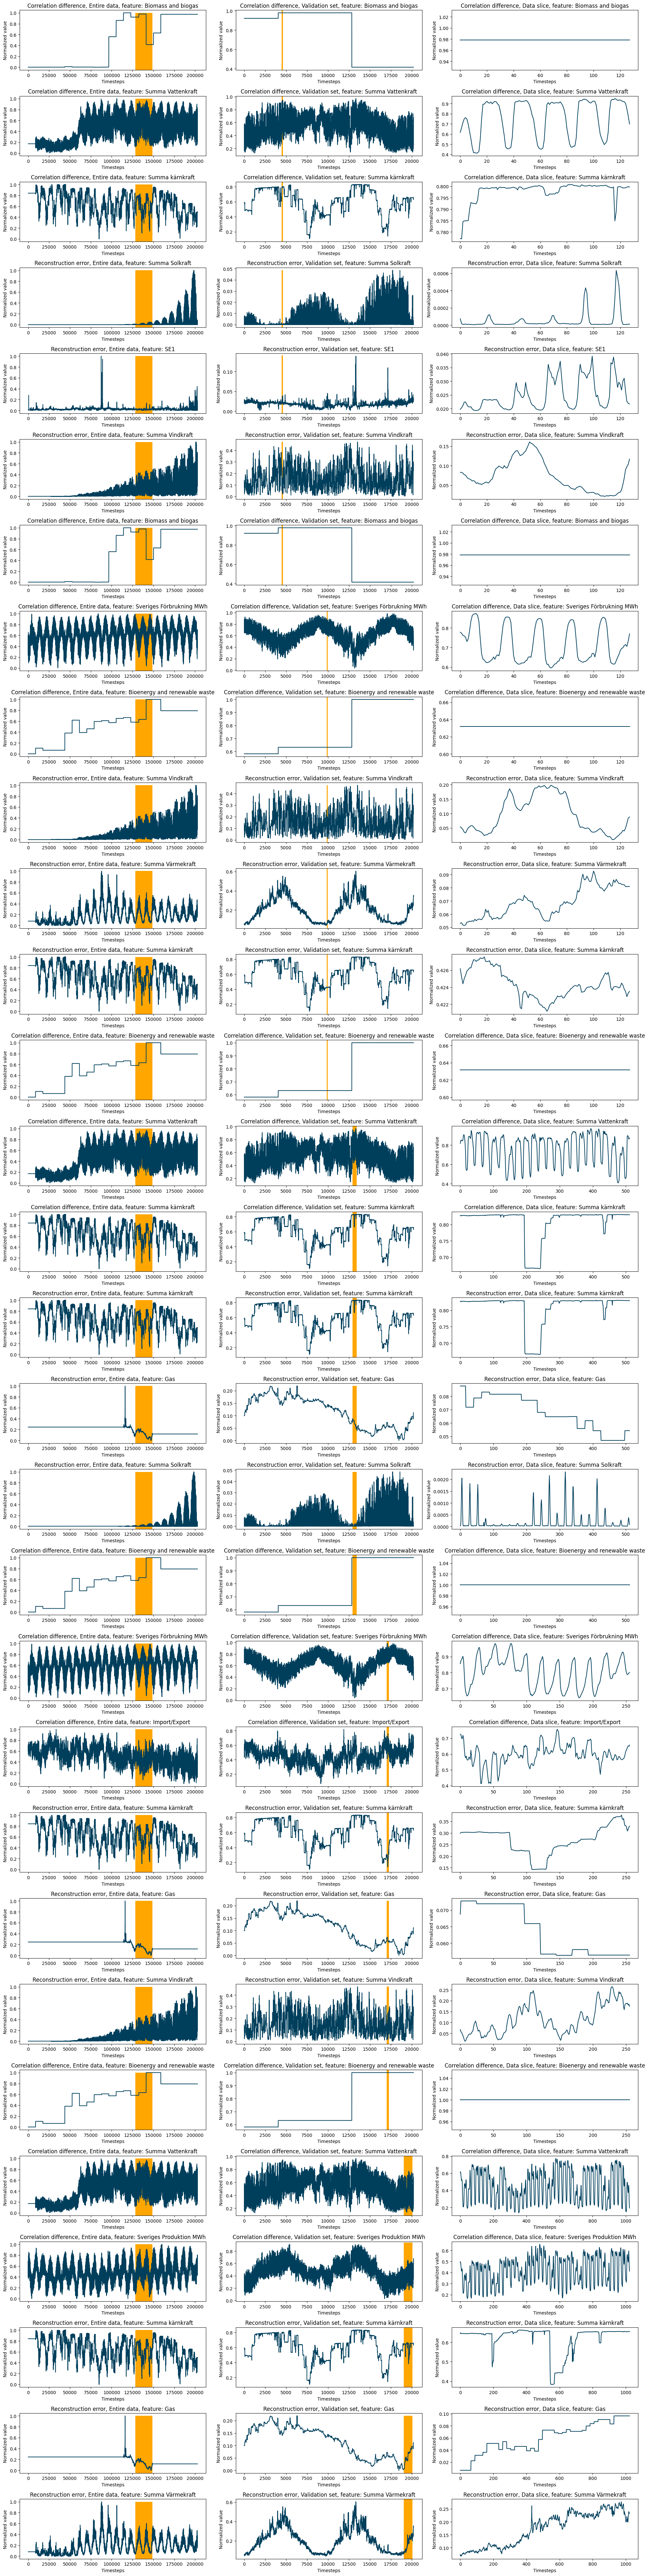

In [188]:
def ocular_analysis(analysis_slices, features, data):
    
    axes = []
    curr_slice = 0
    curr_study = False
    fig, axes = plt.subplots(len(features), 3, figsize = (20,80))
    for i in range(len(features)):
        if i % 3 == 0:
            curr_study = not curr_study
        title = 'Correlation difference' if curr_study else 'Reconstruction error'
        slice = data[analysis_slices[curr_slice]['from']:analysis_slices[curr_slice]['to']]
        feature_to_study = features[i]
        axes[i,0].plot(df.iloc[:,feature_to_study], color=colors[0])
        rectMin0, rectMax0 = axes[i,0].get_ylim()
        axes[i,0].add_patch(Rectangle((val_end-data.shape[0], rectMin0), data.shape[0], rectMax0, facecolor=colors[4], alpha=1, zorder=1))
        axes[i,0].set_ylabel('Normalized value')
        axes[i,0].set_xlabel('Timesteps')
        axes[i,0].set_title(f"{title}, Entire data, feature: {df.columns[feature_to_study]}")
        axes[i,1].plot(data[:,0,feature_to_study], color=colors[0])
        rectMin1, rectMax1 = axes[i,1].get_ylim()
        axes[i,1].add_patch(Rectangle((analysis_slices[curr_slice]['from'], rectMin1), analysis_slices[curr_slice]['to']-analysis_slices[curr_slice]['from'], rectMax1, facecolor=colors[4], alpha=1, zorder=1))
        axes[i,1].set_ylabel('Normalized value')
        axes[i,1].set_xlabel('Timesteps')
        axes[i,1].set_title(f"{title}, Validation set, feature: {df.columns[feature_to_study]}")
        axes[i,2].plot(slice[:,0,feature_to_study], color=colors[0])
        axes[i,2].set_ylabel('Normalized value')
        axes[i,2].set_xlabel('Timesteps')
        axes[i,2].set_title(f"{title}, Data slice, feature: {df.columns[feature_to_study]}")
        #axes[i,2].add_patch(Rectangle((analysis_slices[curr_slice]['from'], 0), analysis_slices[curr_slice]['to']-analysis_slices[curr_slice]['from'], 1, facecolor='#ffa600', alpha=1, zorder=1))
        
        if i % 6 == 0 and i != 0:
            curr_slice += 1
    plt.tight_layout()


    

ocular_analysis(val_slices, analysable_features, X_val)


Differently categorized fossil fuels: 19
Bioenergy and renewable waste: 16
Biomass and biogas: 15
Differently categorized hydro: 9


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

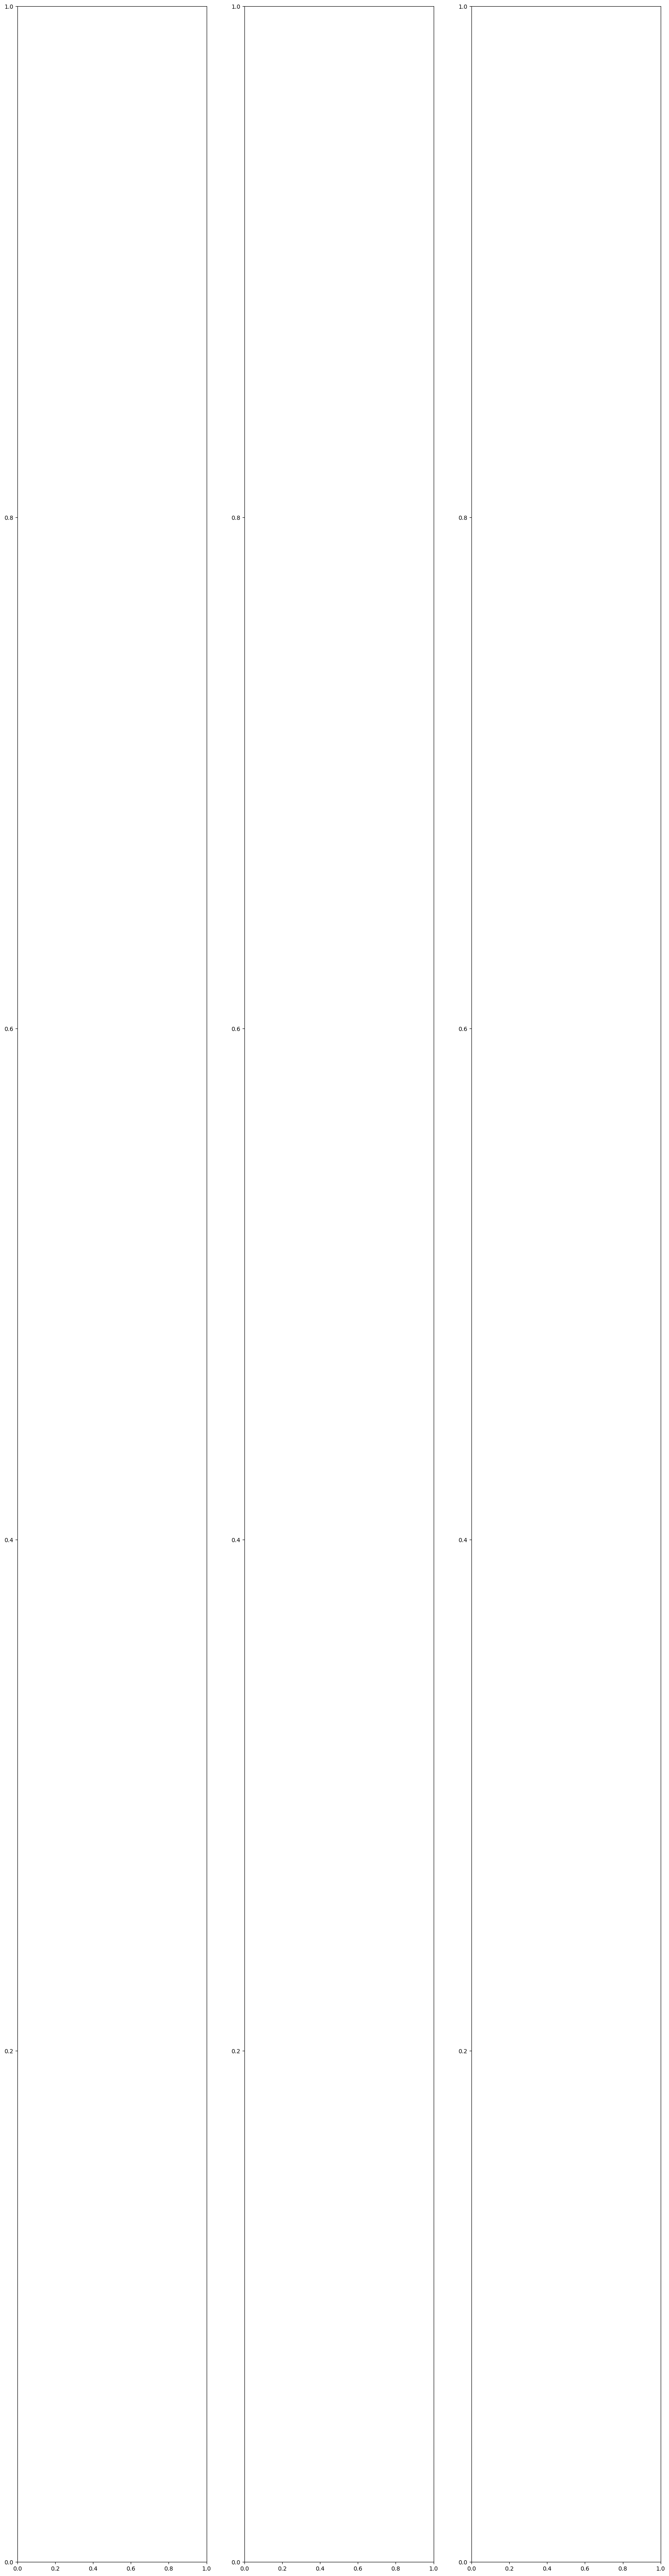

In [189]:
# Find the number of unique values in each column
unique_values = df.nunique()

# Filter out the columns where the number of unique values is less than x
x_unique_values = unique_values[unique_values < 22]

# Get the list of column names with x unique values
columns_with_x_unique_values = list(x_unique_values.index)
sorted_x_unique_values = x_unique_values.sort_values(ascending=False)

for feature, n_unique in sorted_x_unique_values.items():
    print(f"{feature}: {n_unique}")
graphs_per_row = 3
count = 0
axes = []
fig, axes = plt.subplots(len(columns_with_x_unique_values)//graphs_per_row, graphs_per_row, figsize = (20,80))
fig.subplots_adjust(hspace=0.5)  # adjust the height spacing between subplots
for y in range(len(columns_with_x_unique_values)//graphs_per_row):
    for x in range(graphs_per_row):
        axes[y,x].plot(df[columns_with_x_unique_values[count]])
        axes[y,x].set_title(f"Feature: {columns_with_x_unique_values[count]}")
        axes[y,x].set_ylabel('No of unique values')
        axes[y,x].set_xlabel('Timesteps')
        count += 1



               


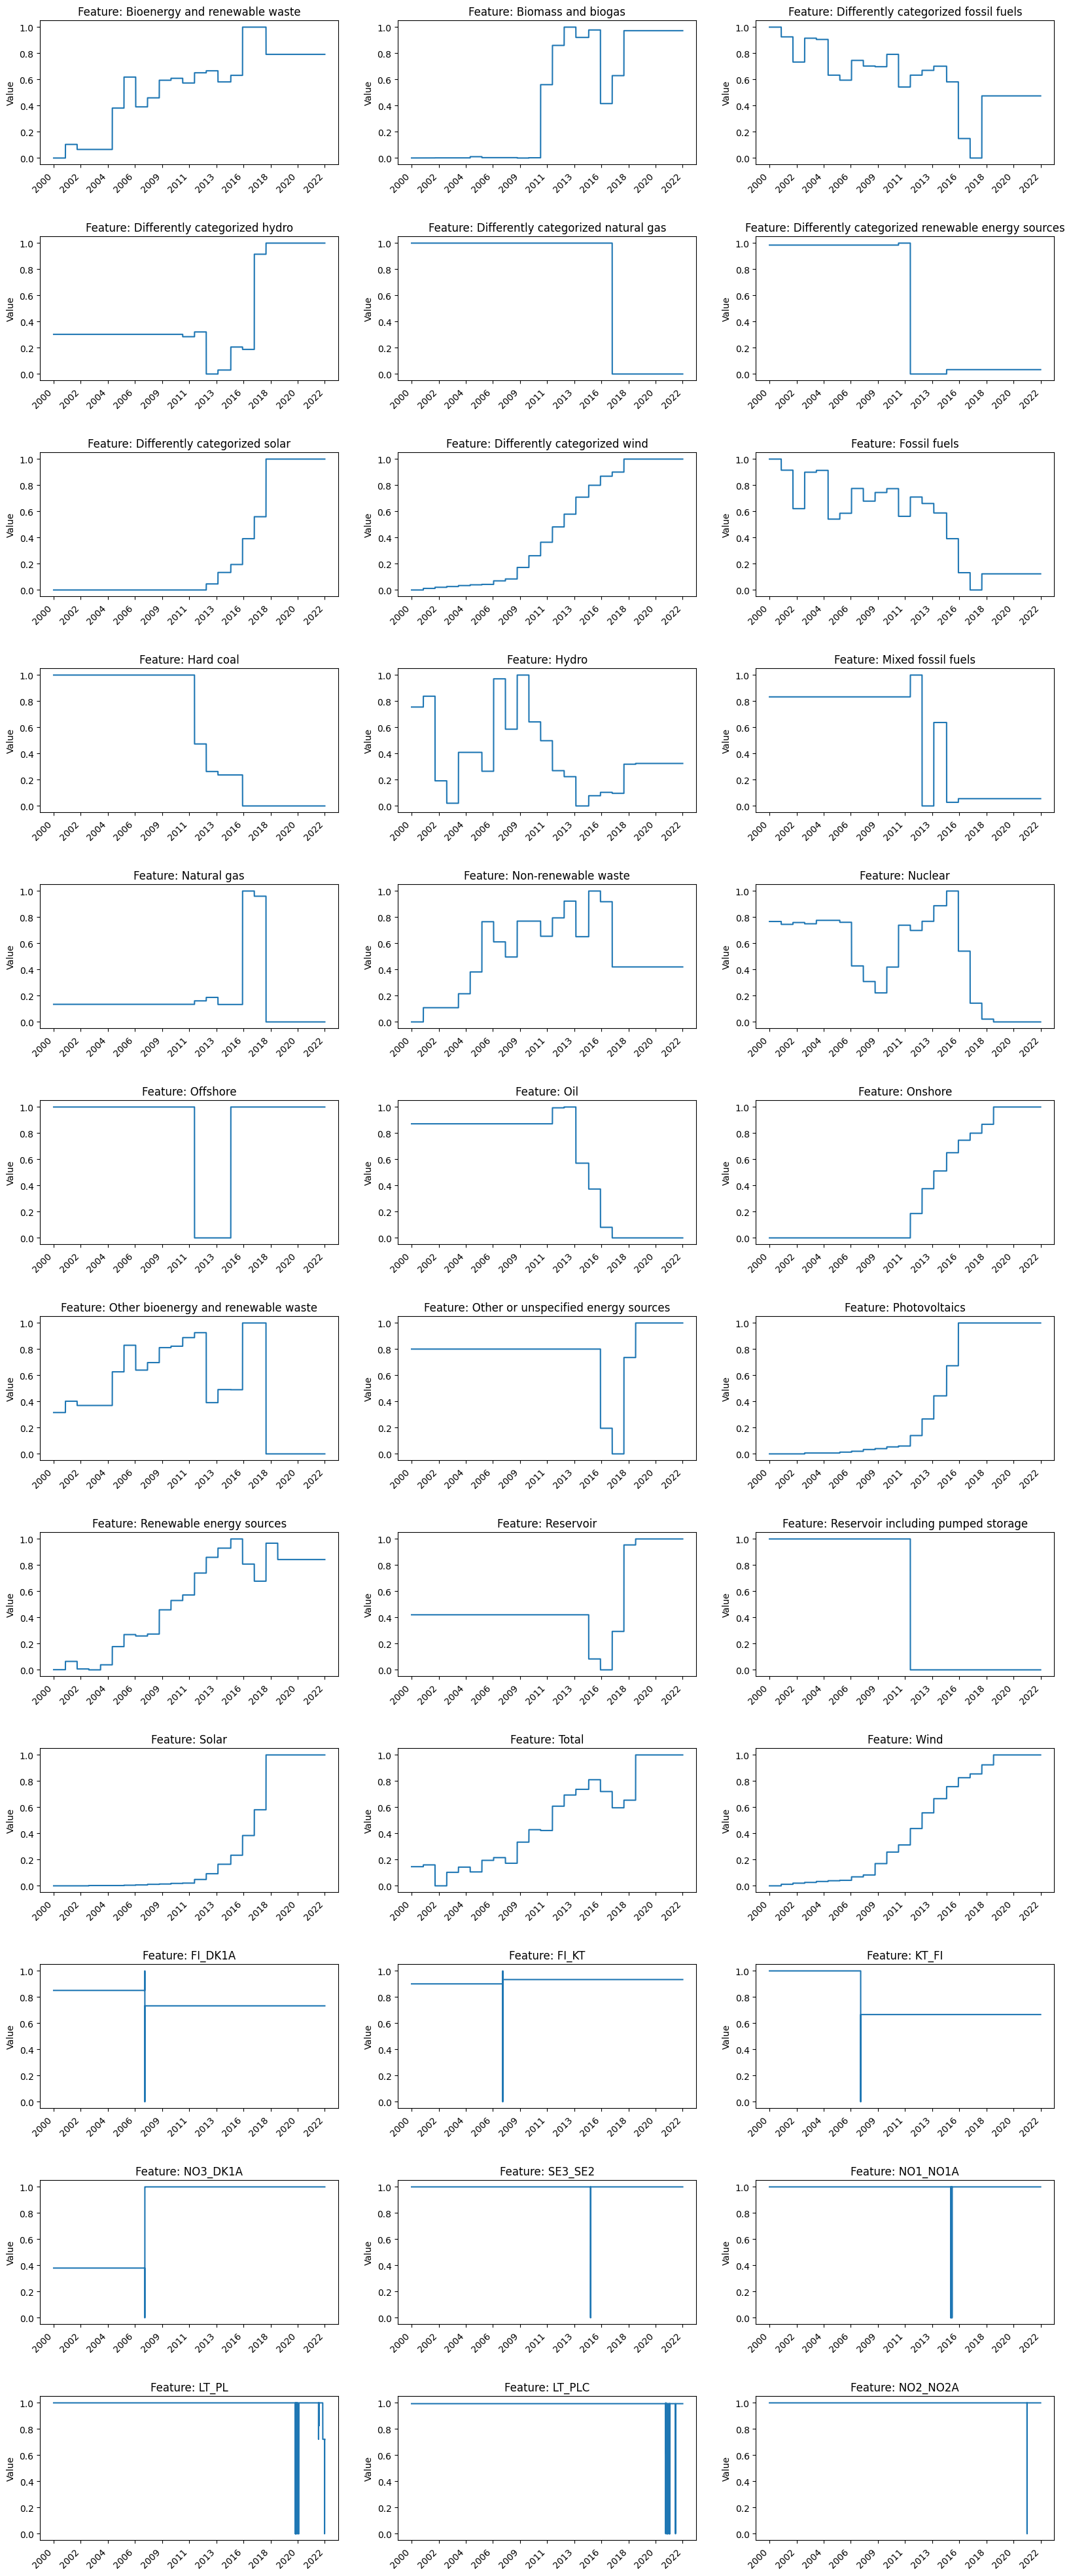

In [ ]:
# Find the number of times each feature changes in value
num_changes = df.diff().ne(0).sum()

# Filter out the features with fewer than x changes
x = 22
changed_features = num_changes[num_changes <= x]

#Create subplots
graphs_per_row = 3
count = 0
axes = []
fig, axes = plt.subplots(len(changed_features)//graphs_per_row, graphs_per_row, figsize = (20,50))
fig.subplots_adjust(hspace = 0.5)  # adjust the height spacing between subplots

#Iterate over each subplot and plot the corresponding feature
for y in range(len(changed_features)//graphs_per_row):
    for x in range(graphs_per_row):
        axes[y,x].plot(df[changed_features.index[count]])
        axes[y,x].set_title(f"Feature: {changed_features.index[count]}")
        axes[y,x].set_ylabel('Value')
        axes[y,x].set_xticks(np.arange(0, len(years), len(years)//10))
        axes[y,x].set_xticklabels(years[::len(years)//10], rotation=45, ha='right')
        count += 1

